In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from sklearn.metrics import make_scorer, recall_score
from scipy.stats import uniform, randint
from tensorflow.keras import layers, models
from hyperopt import fmin, tpe, hp, Trials
from sklearn.metrics import recall_score
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adagrad
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model

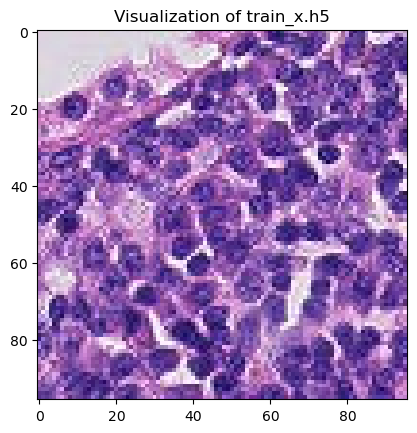

In [2]:
import os
import h5py
import matplotlib.pyplot as plt

folder_path = '/Users/ramsesnestor/Desktop/data'

file_to_dataset = {
    'train_x.h5': 'x',
    'train_y.h5': 'y',
    'valid_x.h5': 'x',
    'valid_y.h5': 'y',
    'test_x.h5': 'x',
    'test_y.h5': 'y'
}

for filename, dataset_name in file_to_dataset.items():
    file_path = os.path.join(folder_path, filename)
    
    with h5py.File(file_path, 'r') as file:
       
        dataset = file[dataset_name]
        
        
        data = dataset[:]
        
 
        if 'train_x.h5' in filename:
            plt.imshow(data[0], cmap='gray')  
            plt.title(f'Visualization of {filename}')
            plt.show()


In [3]:
x_train, y_train, x_valid, y_valid, x_test, y_test = None, None, None, None, None, None


for filename, dataset_name in file_to_dataset.items():
    file_path = os.path.join(folder_path, filename)
    
    with h5py.File(file_path, 'r') as file:
        
        dataset = file[dataset_name]
        
        
        if 'train_x.h5' in filename:
            x_train = dataset[:]
        elif 'train_y.h5' in filename:
            y_train = dataset[:]
        elif 'valid_x.h5' in filename:
            x_valid = dataset[:]
        elif 'valid_y.h5' in filename:
            y_valid = dataset[:]
        elif 'test_x.h5' in filename:
            x_test = dataset[:]
        elif 'test_y.h5' in filename:
            y_test = dataset[:]

In [4]:
len(x_train), len(y_train), len(x_valid), len(y_valid), len(x_test), len(y_test)

(262144, 262144, 32768, 32768, 32768, 32768)

In [5]:
#checking for class imbalance

unique_classes, class_counts = np.unique(y_train, return_counts=True)

for i, class_count in enumerate(class_counts):
    class_name = unique_classes[i]
    print(f"Class {class_name}: {class_count} samples")


Class 0: 131072 samples
Class 1: 131072 samples


In [6]:
x_train = x_train.astype('float32') / 255.0
x_valid = x_valid.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [7]:
x_train_resized = x_train.reshape(x_train.shape[0], 96, 96, 3)
x_valid_resized = x_valid.reshape(x_valid.shape[0], 96, 96, 3)
x_test_resized = x_test.reshape(x_test.shape[0], 96, 96, 3)


In [8]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))

In [9]:


x_train_subset, _, y_train_subset, _ = train_test_split(
    x_train, y_train, train_size=50000, random_state=42
)


In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


datagen.fit(x_train_subset)

In [11]:
x_valid_subset, _, y_valid_subset, _ = train_test_split(
    x_valid, y_valid, train_size=1200, random_state=42
)


In [12]:
x_test_subset, _, y_test_subset, _ = train_test_split(
    x_test, y_test, train_size=1200, random_state=42
)


# Simple

In [10]:

model_1 = Sequential([
    Flatten(input_shape=(96, 96, 3)),  
    Dense(128, activation='relu', kernel_regularizer='l2'), 
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

# Summarize the model architecture
model_1.summary()

Metal device set to: Apple M2 Max
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 128)               3539072   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,539,713
Trainable params: 3,539,457
Non-trainable params: 256
__________

2023-09-21 17:20:57.534169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-21 17:20:57.534706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
history_1 = model_1.fit(datagen.flow(x_train_resized, y_train, batch_size=16),
                        validation_data=(x_valid_resized, y_valid),
                    
                     steps_per_epoch=len(x_train_resized)/16, epochs=10)

Epoch 1/10


2023-09-21 17:21:22.181701: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-21 17:21:22.449641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16384/16384 [==============================] - ETA: 0s - loss: 0.8462 - accuracy: 0.5566 - precision: 0.5544 - recall: 0.5767 - auc: 0.5844

2023-09-21 17:26:10.658321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16384/16384 [==============================] - 295s 18ms/step - loss: 0.8462 - accuracy: 0.5566 - precision: 0.5544 - recall: 0.5767 - auc: 0.5844 - val_loss: 1.0324 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5958
Epoch 2/10
16384/16384 [==============================] - 372s 23ms/step - loss: 0.7881 - accuracy: 0.5490 - precision: 0.5460 - recall: 0.5820 - auc: 0.5687 - val_loss: 0.8842 - val_accuracy: 0.4995 - val_precision: 0.4995 - val_recall: 1.0000 - val_auc: 0.5839
Epoch 3/10
16384/16384 [==============================] - 316s 19ms/step - loss: 0.7761 - accuracy: 0.5434 - precision: 0.5404 - recall: 0.5810 - auc: 0.5602 - val_loss: 0.8663 - val_accuracy: 0.4995 - val_precision: 0.4995 - val_recall: 1.0000 - val_auc: 0.5797
Epoch 4/10
16384/16384 [==============================] - 314s 19ms/step - loss: 0.7649 - accuracy: 0.5425 - precision: 0.5396 - recall: 0.5790 - auc: 0.5575 - val_loss: 0.7189 - val_accuracy: 0.4995 - val_precisio

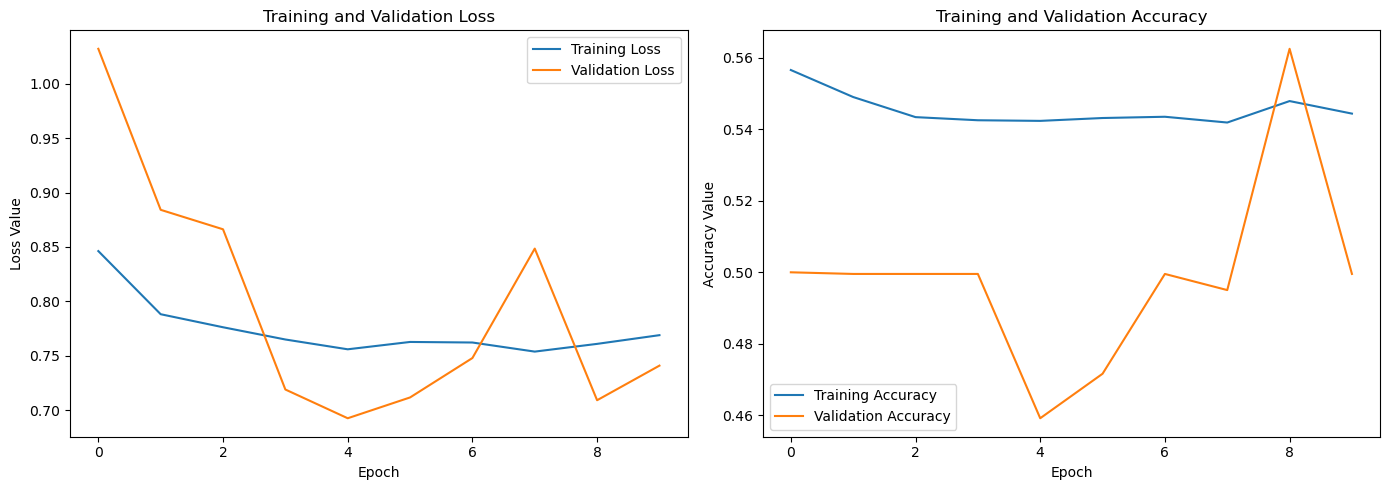

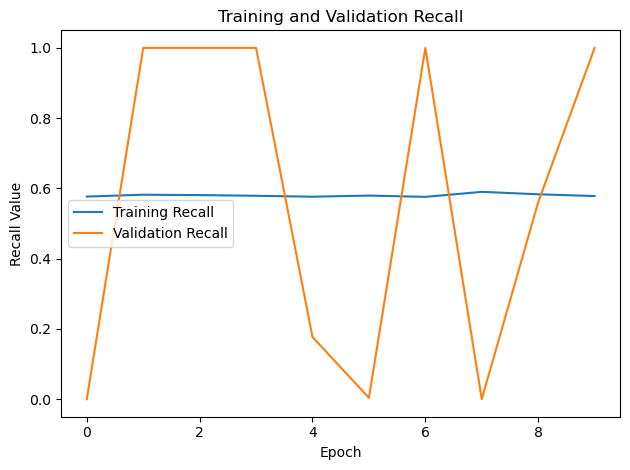

In [12]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_1.history['recall'], label='Training Recall')
plt.plot(history_1.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

# Dense

In [12]:

model_2 = Sequential([
    Flatten(input_shape=(96, 96, 3)),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'Recall'])

model_2.summary()

Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 64)                1769536   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                        

2023-09-22 15:15:36.184897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-22 15:15:36.185765: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
history_2 = model_2.fit(datagen.flow(x_train_subset, y_train_subset, batch_size=16),
                        validation_data=(x_valid_subset, y_valid_subset),
                         steps_per_epoch=len(x_train_subset)/16, epochs=10)

Epoch 1/10


2023-09-22 15:15:39.667039: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-22 15:15:39.891300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6248/6250 [============================>.] - ETA: 0s - loss: 0.8874 - accuracy: 0.4992 - recall: 0.4039

2023-09-22 15:17:16.340439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6250/6250 [==============================] - 100s 16ms/step - loss: 0.8874 - accuracy: 0.4993 - recall: 0.4038 - val_loss: 0.6932 - val_accuracy: 0.5015 - val_recall: 0.0000e+00
Epoch 2/10
6250/6250 [==============================] - 98s 16ms/step - loss: 0.6932 - accuracy: 0.5015 - recall: 0.3400 - val_loss: 0.6932 - val_accuracy: 0.4985 - val_recall: 1.0000
Epoch 3/10
6250/6250 [==============================] - 98s 16ms/step - loss: 0.6932 - accuracy: 0.4963 - recall: 0.4741 - val_loss: 0.6931 - val_accuracy: 0.4985 - val_recall: 1.0000
Epoch 4/10
6250/6250 [==============================] - 98s 16ms/step - loss: 0.6932 - accuracy: 0.5020 - recall: 0.4375 - val_loss: 0.6932 - val_accuracy: 0.5015 - val_recall: 0.0000e+00
Epoch 5/10
6250/6250 [==============================] - 97s 15ms/step - loss: 0.6932 - accuracy: 0.4995 - recall: 0.4477 - val_loss: 0.6932 - val_accuracy: 0.4985 - val_recall: 1.0000
Epoch 6/10
6250/6250 [==============================] - 98s 16ms/step - loss: 0.69

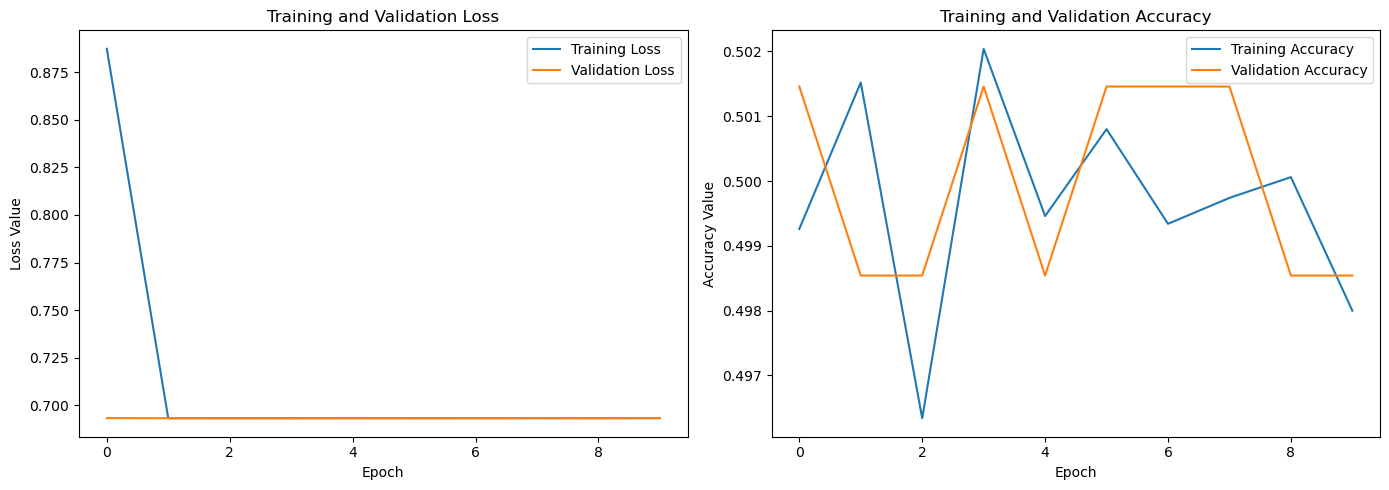

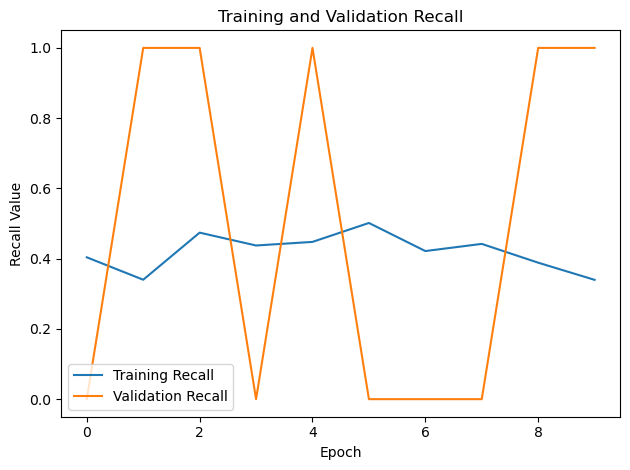

In [15]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_2.history['recall'], label='Training Recall')
plt.plot(history_2.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

# CNN 1

In [13]:

model_cnn = Sequential()

# Convolutional layers
model_cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model_cnn.add(Dropout(0.5))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.004)))
model_cnn.add(Dropout(0.5))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.004)))
model_cnn.add(Dropout(0.5))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.004)))
model_cnn.add(Dropout(0.5))
model_cnn.add(MaxPooling2D(2, 2))

# Fully connected layers
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu', kernel_regularizer))
model_cnn.add(Dropout(0.5012121580601727))
model_cnn.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the CNN model
optimizer=Adagrad(learning_rate=0.01)
model_cnn.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy', 'Recall'])

# Model summary
model_cnn.summary()

Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-09-23 00:18:32.296689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-23 00:18:32.298424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 64)        1792      
                                                                 
 dropout (Dropout)           (None, 94, 94, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        36928     
                                                                 
 dropout_1 (Dropout)         (None, 45, 45, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                    

In [14]:
class_weights = {0: 1, 1: 2}
history_cnn = model_cnn.fit(datagen.flow(x_train_subset, y_train_subset, batch_size=16),
                        validation_data=(x_valid_subset, y_valid_subset),
                         steps_per_epoch=len(x_train_subset)/16, epochs=10, class_weight=class_weights)

Epoch 1/10


2023-09-23 00:18:32.943069: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-23 00:18:33.230764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3123/3125 [============================>.] - ETA: 0s - loss: 1.3982 - accuracy: 0.7056 - recall: 0.8911

2023-09-23 00:19:26.728622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3125/3125 [==============================] - 54s 17ms/step - loss: 1.3979 - accuracy: 0.7057 - recall: 0.8911 - val_loss: 0.9688 - val_accuracy: 0.5300 - val_recall: 0.9967
Epoch 2/10
3125/3125 [==============================] - 54s 17ms/step - loss: 0.8909 - accuracy: 0.7700 - recall: 0.8940 - val_loss: 0.7755 - val_accuracy: 0.5358 - val_recall: 0.9967
Epoch 3/10
3125/3125 [==============================] - 54s 17ms/step - loss: 0.7669 - accuracy: 0.7830 - recall: 0.8990 - val_loss: 0.7263 - val_accuracy: 0.5400 - val_recall: 0.9967
Epoch 4/10
3125/3125 [==============================] - 54s 17ms/step - loss: 0.7266 - accuracy: 0.7920 - recall: 0.9022 - val_loss: 0.6972 - val_accuracy: 0.6042 - val_recall: 0.9600
Epoch 5/10
3125/3125 [==============================] - 54s 17ms/step - loss: 0.7080 - accuracy: 0.7991 - recall: 0.9026 - val_loss: 0.6885 - val_accuracy: 0.5983 - val_recall: 0.9867
Epoch 6/10
3125/3125 [==============================] - 55s 18ms/step - loss: 0.6976 - accu

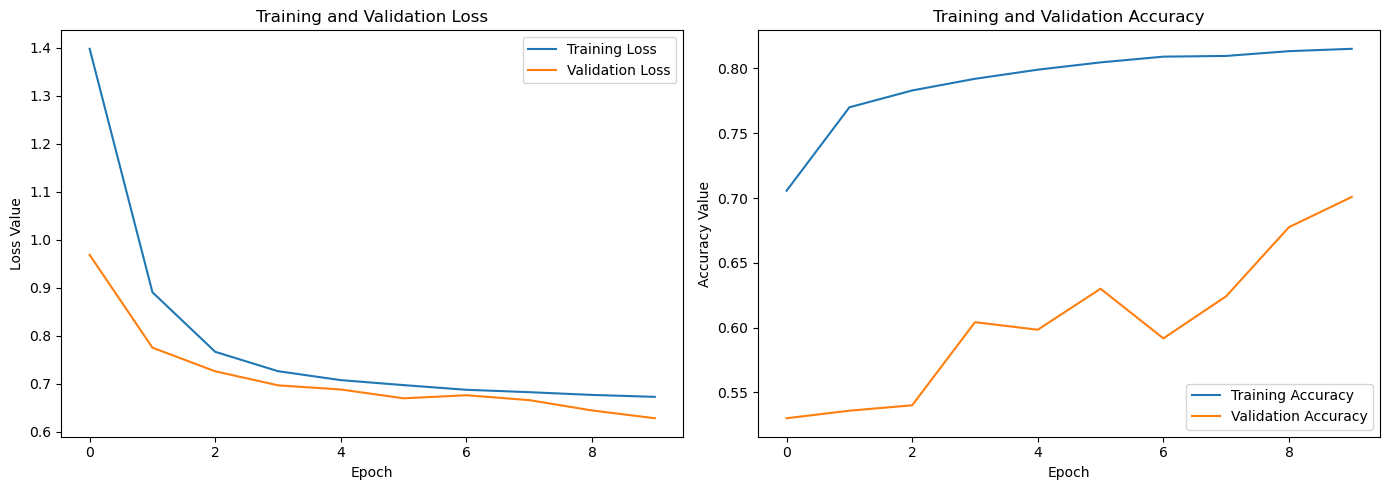

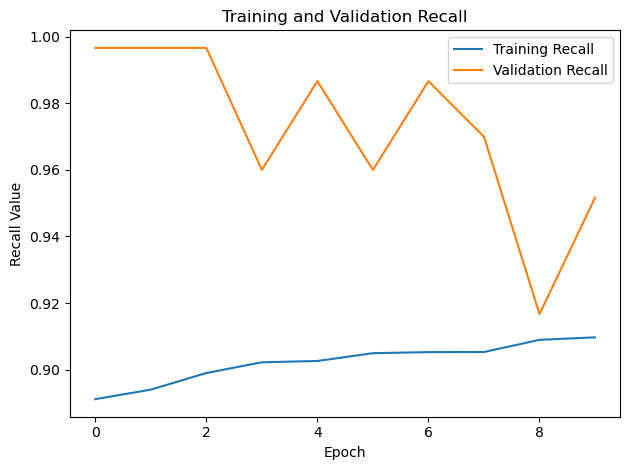

In [15]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_cnn.history['recall'], label='Training Recall')
plt.plot(history_cnn.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

# CNN2 SGD optimizer

In [ ]:
model_cnn2 = Sequential() #sgd optimizer

# Convolutional layers
model_cnn2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model_cnn2.add(MaxPooling2D(2, 2))
model_cnn2.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D(2, 2))
model_cnn2.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D(2, 2))
model_cnn2.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D(2, 2))

# Fully connected layers
model_cnn2.add(Flatten())
model_cnn2.add(Dense(512, activation='relu'))
model_cnn2.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the CNN model
model_cnn2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

# Model summary
model_cnn2.summary()

In [ ]:
history_cnn2 = model_cnn2.fit(datagen.flow(x_train_final, y_train_final, batch_size=16), 
                                    validation_data=(x_val_final, y_val_final),
                                    steps_per_epoch=len(x_train_final)/16, epochs=10)

In [ ]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn2.history['loss'], label='Training Loss')
plt.plot(history_cnn2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn2.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_cnn2.history['recall'], label='Training Recall')
plt.plot(history_cnn2.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

# CNN with hyperparams from random search :(

In [14]:

model_cnn3 = Sequential()

# Convolutional layers
model_cnn3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3), kernel_regularizer='l2'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Dropout(0.5))

model_cnn3.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l2'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Dropout(0.5))

model_cnn3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Dropout(0.5))

    # Flatten layer to convert the 2D feature maps to 1D feature vectors
model_cnn3.add(Flatten())

    # Fully connected layers
model_cnn3.add(Dense(512, activation='relu', kernel_regularizer='l2'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(Dropout(0.5))

    # Output layer
model_cnn3.add(Dense(1, activation='sigmoid'))

# Compile the CNN model
optimizer = Adagrad(learning_rate=0.06516691237683736)
model_cnn3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

# Model summary
model_cnn3.summary()

2023-09-22 20:05:30.351672: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-22 20:05:30.352377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                        

In [15]:
history_cnn3 = model_cnn3.fit(datagen.flow(x_train_subset, y_train_subset, batch_size=16),
                        validation_data=(x_valid_subset, y_valid_subset),
                         steps_per_epoch=len(x_train_subset)/16, epochs=10)

Epoch 1/10


2023-09-22 20:05:30.747401: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-22 20:05:31.139515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3125/3125 [==============================] - ETA: 0s - loss: 1.2742 - accuracy: 0.7146 - recall: 0.7342

2023-09-22 20:06:25.590991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3125/3125 [==============================] - 56s 17ms/step - loss: 1.2742 - accuracy: 0.7146 - recall: 0.7342 - val_loss: 76.0617 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 2/10
3125/3125 [==============================] - 54s 17ms/step - loss: 0.6266 - accuracy: 0.7449 - recall: 0.7560 - val_loss: 293.9859 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 3/10
3125/3125 [==============================] - 54s 17ms/step - loss: 0.6077 - accuracy: 0.7528 - recall: 0.7461 - val_loss: 495.1024 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 4/10
3125/3125 [==============================] - 54s 17ms/step - loss: 0.5958 - accuracy: 0.7601 - recall: 0.7504 - val_loss: 660.4536 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 5/10
3125/3125 [==============================] - 54s 17ms/step - loss: 0.5876 - accuracy: 0.7637 - recall: 0.7493 - val_loss: 512.0167 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 6/10
3125/3125 [==============================] - 55s 17

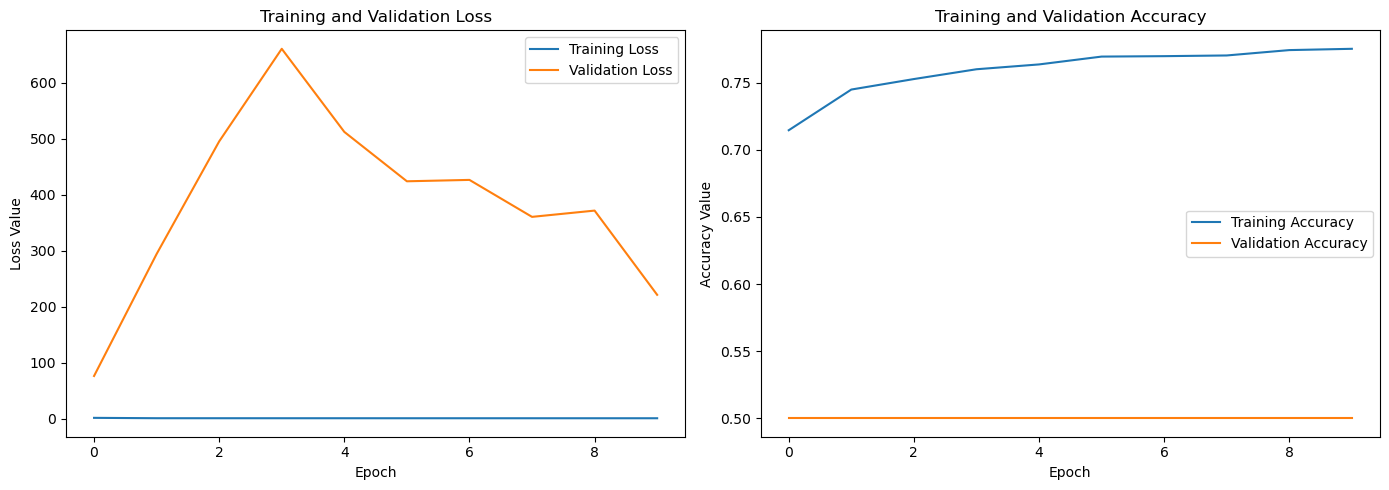

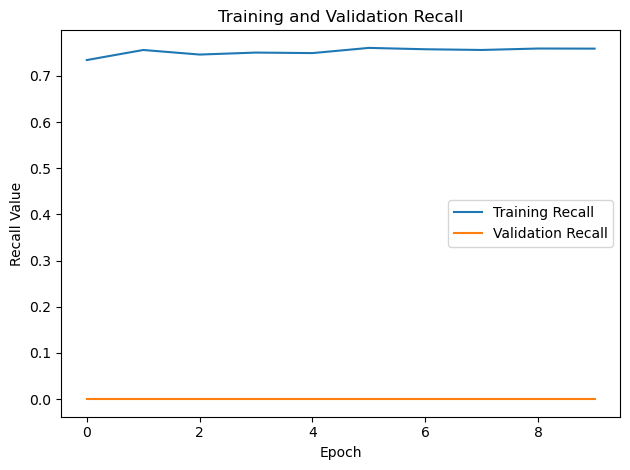

In [16]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn3.history['loss'], label='Training Loss')
plt.plot(history_cnn3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn3.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_cnn3.history['recall'], label='Training Recall')
plt.plot(history_cnn3.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

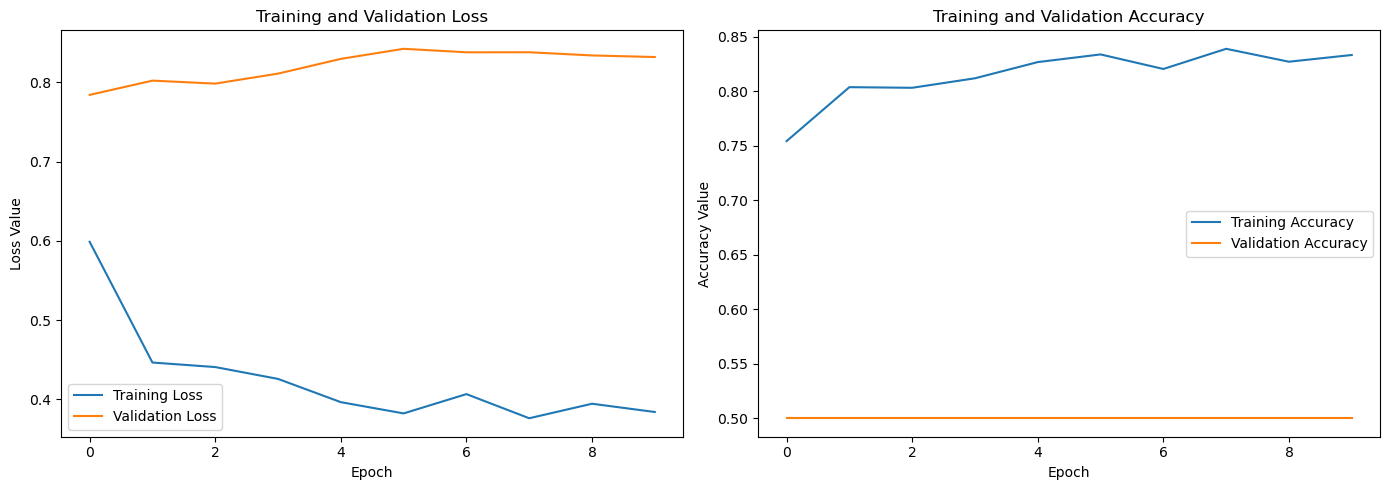

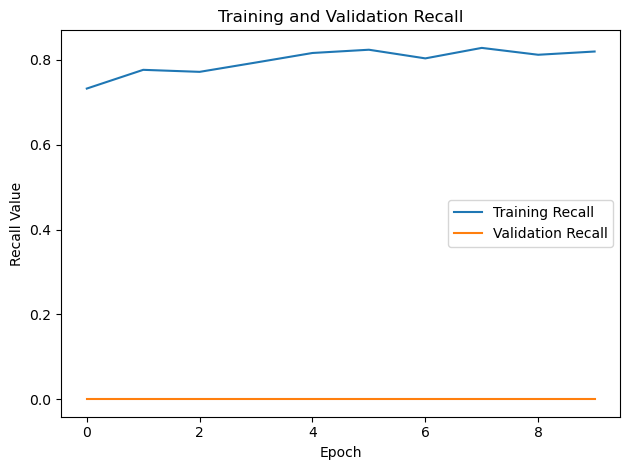

In [21]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()